In [26]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

In [27]:
# Load the dataset
marc_anne_data = pd.read_excel("Marc_Anne_HR_Variability_MSA.xlsx")


In [28]:
# Convert date columns to datetime
marc_anne_data['Date_de_l_examen'] = pd.to_datetime(marc_anne_data['Date_de_l_examen'])
marc_anne_data['date_'] = pd.to_datetime(marc_anne_data['date_'])

In [29]:
# Calculate follow-up duration
marc_anne_data['Followup_duration'] = (marc_anne_data['Date_de_l_examen'] - marc_anne_data['date_']).dt.days / 365.25

In [30]:
marc_anne_data.columns

Index(['patid', 'Sexe_', 'DDN', 'Date_de_l_examen', 'Age_lors_de_l_examen',
       'ms/mmHg', 'Mean_RR_(ms)', 'pNN50_(%)', 'SDNN_(ms)', 'rMSSD_(ms)',
       ...
       'COMPASS_score_orthostatisme', 'COMPASS_score_vasomoteur',
       'COMPASS_score_secretomoteur', 'COMPASS_score_gastro-intestinal',
       'COMPASS_score_vessie', 'COMPASS_score_pupillomoteur', 'fin_de_suivi_',
       'cause', 'date_', 'Followup_duration'],
      dtype='object', length=188)

In [31]:

# If column names have special characters (e.g., / or -), rename them
marc_anne_data.columns = marc_anne_data.columns.str.replace("-", "_").str.replace("/", "_")

# Select the desired range of columns and additional columns for processing
cols_to_select = list(marc_anne_data.loc[:, "ms_mmHg":"Hurst"].columns)  # Select range from 'ms_mmHg' to 'Hurst'
additional_cols = ["Score_UMSARS1", "Score_UMSARS2", "Followup_duration"]
final_columns = cols_to_select + additional_cols

# Select relevant columns
marc_anne_data = marc_anne_data[final_columns]



In [32]:
# Create the UMSARS score and drop unused columns
marc_anne_data['UMSARS'] = marc_anne_data['Score_UMSARS1'] + marc_anne_data['Score_UMSARS2']
marc_anne_data = marc_anne_data.drop(columns=['Score_UMSARS1', 'Score_UMSARS2'])

In [33]:
marc_anne_data

,ms_mmHg,Mean_RR_(ms),pNN50_(%),SDNN_(ms),rMSSD_(ms),Ptot_(ms²),VLF_(ms²),LF_(ms²),HF_(ms²),LF_HF,...,MP,MP%,α1_(DFA),α2_(DFA),H_(DFA),H_(Higuchi),H_(Katz),Hurst,Followup_duration,UMSARS
0,3.493,890.0,0.30,26.7,20.1,314.62,103.33,107.52,43.01,2.50,...,155.0,46.55,0.852,0.917,1.108,1.933,1.935,0.089,-2.453114,91.0
1,3.643,823.0,0.00,17.7,11.7,173.99,115.06,26.76,21.15,1.27,...,156.0,43.09,0.858,1.133,1.103,1.864,1.611,0.206,-4.709103,33.0
2,2.866,770.0,0.00,13.0,7.7,162.24,107.36,21.60,19.38,1.11,...,172.0,47.51,1.059,1.152,1.076,1.850,1.452,0.220,-7.274470,35.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.648871,57.0
4,5.445,777.0,0.52,15.4,13.6,125.40,42.87,18.08,33.09,0.55,...,131.0,34.20,0.776,0.993,0.949,1.937,1.635,0.101,-2.606434,52.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209,5.589,743.0,0.74,26.2,15.9,835.28,404.84,374.62,28.00,13.38,...,184.0,45.89,1.611,0.921,0.866,1.510,1.617,0.406,-3.802875,53.0
210,4.503,636.0,0.00,16.3,3.4,99.71,83.05,5.77,2.78,2.08,...,182.0,38.81,1.170,1.546,1.400,1.741,1.220,0.304,-2.893908,NaN
211,5.670,780.0,0.00,12.0,13.4,97.03,20.20,34.33,22.38,1.53,...,143.0,37.43,0.640,0.818,0.879,1.986,1.670,0.060,-4.164271,NaN
212,8.816,806.0,4.31,47.1,24.9,1360.73,297.85,667.86,338.70,1.97,...,163.0,44.17,1.150,0.964,0.950,1.574,1.911,0.326,-4.939083,NaN


In [34]:
# Drop rows with missing values
marc_anne_data = marc_anne_data.dropna()

In [35]:
marc_anne_data.shape

(117, 52)

In [36]:
# Clean column names
marc_anne_data.columns = marc_anne_data.columns.str.replace(r"[-/()%²]", "_", regex=True)
marc_anne_data.columns = marc_anne_data.columns.str.replace("1", "one").str.replace("2", "two").str.replace("%", "perc")

In [37]:
# Standardize numeric columns
scaler = StandardScaler()
numeric_cols = marc_anne_data.select_dtypes(include=np.number).columns
marc_anne_data[numeric_cols] = scaler.fit_transform(marc_anne_data[numeric_cols])

<ipython-input-37-11a25d17e0d1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  marc_anne_data[numeric_cols] = scaler.fit_transform(marc_anne_data[numeric_cols])


In [38]:
# Split the data into predictors (X) and target (y)
X = marc_anne_data.drop(columns=['Followup_duration'])
y = marc_anne_data['Followup_duration']

In [39]:
X

,ms_mmHg,Mean_RR__ms_,pNN50____,SDNN__ms_,rMSSD__ms_,Ptot__ms__,VLF__ms__,LF__ms__,HF__ms__,LF_HF,...,twoUV_,MP,MP_,αone__DFA_,αtwo__DFA_,H__DFA_,H__Higuchi_,H__Katz_,Hurst,UMSARS
0,-0.138176,0.870537,-0.276995,0.584034,0.275710,-0.221897,-0.369866,-0.015783,-0.152046,-0.123740,...,1.788915,-0.467356,0.318481,-0.511827,-0.732762,0.777818,0.819063,0.592472,-1.012727,2.929549
1,-0.092384,0.248237,-0.307660,-0.214973,-0.244182,-0.427376,-0.333237,-0.420747,-0.241783,-0.543629,...,0.636650,-0.415477,-0.132157,-0.494296,0.391334,0.744110,0.422809,-0.126299,-0.171971,-1.052009
2,-0.329585,-0.244030,-0.307660,-0.632233,-0.491749,-0.444545,-0.357282,-0.446621,-0.249049,-0.598249,...,-0.267901,0.414590,0.443514,0.093000,0.490213,0.562087,0.342409,-0.479029,-0.071368,-0.914714
4,0.457726,-0.179013,-0.254506,-0.419164,-0.126587,-0.498373,-0.558662,-0.464272,-0.192768,-0.789417,...,0.432886,-1.712457,-1.290011,-0.733890,-0.337247,-0.294094,0.842035,-0.073057,-0.926496,0.252294
9,1.099725,1.706462,-0.137977,0.504134,0.176683,0.769996,0.473752,1.803831,0.228701,0.207391,...,-0.207172,1.555932,2.705824,-0.161202,0.245618,-0.334544,0.043783,0.370629,0.022049,-0.022296
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,-0.607082,1.353516,-0.210553,-0.108439,0.275710,-0.441462,-0.331333,-0.464071,-0.248926,-0.659696,...,-0.779309,1.711570,2.453153,-0.584874,0.047860,0.386806,0.715693,-0.128517,-0.825893,-0.777419
204,-0.622957,-1.284292,-0.307660,-0.685500,-0.330831,-0.492119,-0.419423,-0.505089,-0.308942,-0.270531,...,1.605128,-1.504940,-1.863078,-0.947186,0.844095,1.087931,0.905206,-0.303773,-0.833079,-0.296886
205,-0.551827,0.721928,-0.307660,-0.800912,-0.553641,-0.461479,-0.411148,-0.391011,-0.276553,-0.096431,...,-0.348608,-0.156081,0.422675,0.309219,0.219597,0.022760,-0.185930,-0.601043,0.086723,-0.022296
206,2.140111,1.799342,0.439557,0.885882,1.166953,0.045900,-0.476974,0.315970,0.343356,-0.615317,...,-1.222795,1.555932,2.705824,0.008266,-1.940125,-2.626683,0.715693,0.707831,-1.142074,0.732827


In [40]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [41]:
X_train.head()

,ms_mmHg,Mean_RR__ms_,pNN50____,SDNN__ms_,rMSSD__ms_,Ptot__ms__,VLF__ms__,LF__ms__,HF__ms__,LF_HF,...,twoUV_,MP,MP_,αone__DFA_,αtwo__DFA_,H__DFA_,H__Higuchi_,H__Katz_,Hurst,UMSARS
16,0.863440,1.409244,-0.274950,0.663935,0.102413,0.233043,0.181346,0.446997,0.052305,-0.243221,...,-0.195985,-0.259839,0.851173,0.607250,-0.659904,-0.381735,-0.984182,0.366193,0.438834,-0.502829
52,0.318214,-1.340020,-0.307660,-0.978469,-0.497939,-0.617646,-0.639852,-0.501880,-0.312554,-0.055466,...,0.282660,-0.519235,-1.355133,-0.479687,0.110310,0.002535,0.600836,-0.518961,-0.775591,-0.708771
198,-1.053093,-0.838465,-0.307660,-1.324706,-0.764074,-0.652713,-0.659275,-0.529810,-0.317234,-0.359288,...,0.066111,-0.104202,-0.720852,0.116375,0.391334,-0.644657,-0.295043,-1.018108,0.366975,0.458237
118,-1.031724,0.350406,-0.221797,-0.285996,-0.033750,-0.107826,0.004541,-0.294935,-0.154221,-0.560697,...,-0.764925,1.452174,1.260134,0.835156,1.052261,-0.064881,-0.128502,-0.310429,0.309487,-1.601189
47,0.437578,1.464972,-0.307660,0.592912,0.003386,0.535498,0.631384,0.975415,-0.042686,0.518040,...,-0.259911,0.258953,1.333069,0.960797,-0.691129,-0.031173,-0.674069,0.295203,0.618483,0.526885


In [42]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Ensure TensorFlow is installed and working
print(f"TensorFlow version: {tf.__version__}")


TensorFlow version: 2.17.1


In [43]:
# Neural Network using TensorFlow/Keras
def build_and_train_nn(X_train, X_test, y_train, y_test):
    # Define the model
    model = Sequential([
        Dense(128, activation='relu', input_shape=(X_train.shape[1],)),  # 1st hidden layer
        Dropout(0.2),  # Dropout to prevent overfitting
        Dense(64, activation='relu'),  # 2nd hidden layer
        Dropout(0.2),  # Dropout to prevent overfitting
        Dense(32, activation='relu'),  # 3rd hidden layer
        Dropout(0.2),
        Dense(1, activation='linear')  # Output layer for regression
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=1000,
        batch_size=32,
        verbose=1
    )

    # Evaluate the model
    y_pred = model.predict(X_test).flatten()
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Neural Network: MSE = {mse:.3f}, R^2 = {r2:.3f}")

    # Plot training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Squared Error')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    # Return the trained model and predictions
    return model, y_pred


Epoch 1/1000


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 189ms/step - loss: 1.1999 - mae: 0.8210 - val_loss: 1.4441 - val_mae: 0.9657
Epoch 2/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.9177 - mae: 0.7271 - val_loss: 1.4087 - val_mae: 0.9543
Epoch 3/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.9092 - mae: 0.7647 - val_loss: 1.3853 - val_mae: 0.9524
Epoch 4/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.9759 - mae: 0.7792 - val_loss: 1.3608 - val_mae: 0.9541
Epoch 5/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.9804 - mae: 0.7689 - val_loss: 1.3396 - val_mae: 0.9540
Epoch 6/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.8102 - mae: 0.6909 - val_loss: 1.3205 - val_mae: 0.9503
Epoch 7/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.7566 - mae: 0.6441 - val_loss: 1.3041 - val_mae: 0.9448
Epoch 8/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.9691 - mae: 0.7512 - val_loss: 1.2900 - val_mae: 0.9419
Epoch 9/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.7545 - mae: 0.6

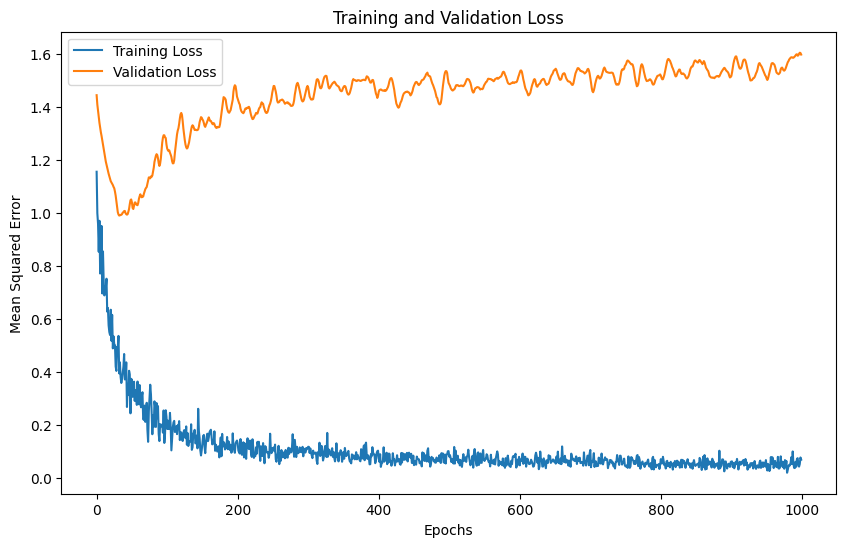

In [44]:

# Train the model
nn_model, nn_predictions = build_and_train_nn(X_train, X_test, y_train, y_test)


In [46]:
!pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.6 MB/s eta 0:00:00


In [47]:
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import mean_squared_error, r2_score

# Define the model building function
def build_nn_model(hp):
    model = Sequential()
    # Input Layer
    model.add(Dense(
        units=hp.Int('units_input', min_value=32, max_value=128, step=32),
        activation='relu', input_shape=(X_train.shape[1],)
    ))
    # Hidden Layers
    for i in range(hp.Int('num_layers', 1, 5)):  # Vary number of hidden layers
        model.add(Dense(
            units=hp.Int(f'units_{i}', min_value=32, max_value=128, step=32),
            activation='relu'
        ))
        model.add(Dropout(hp.Float('dropout', 0.1, 0.5, step=0.1)))
    # Output Layer
    model.add(Dense(1, activation='linear'))  # Regression output
    # Compile Model
    model.compile(
        optimizer=hp.Choice('optimizer', ['adam', 'rmsprop', 'sgd']),
        loss='mse', metrics=['mae']
    )
    return model

In [48]:

# Hyperparameter tuner
tuner = kt.RandomSearch(
    build_nn_model,
    objective='val_loss',
    max_trials=10,  # Number of models to try
    executions_per_trial=2,  # Average over multiple runs
    directory='my_dir',
    project_name='tune_nn'
)

# Run the search
tuner.search(X_train, y_train, epochs=50, validation_split=0.2, verbose=1)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
Optimal Number of Layers: {best_hps.get('num_layers')}
Optimal Units in Input Layer: {best_hps.get('units_input')}
Dropout Rate: {best_hps.get('dropout')}
Optimizer: {best_hps.get('optimizer')}
""")

# Build and train the best model
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train, y_train, validation_split=0.2, epochs=100, verbose=1)

# Evaluate on test set
y_pred = best_model.predict(X_test).flatten()
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Optimized Neural Network: MSE = {mse:.3f}, R^2 = {r2:.3f}")


Trial 10 Complete [00h 00m 14s]
val_loss: 0.9885617196559906

Best val_loss So Far: 0.9360233247280121
Total elapsed time: 00h 02m 39s

Optimal Number of Layers: 5
Optimal Units in Input Layer: 32
Dropout Rate: 0.1
Optimizer: adam

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 200ms/step - loss: 1.0149 - mae: 0.7440 - val_loss: 1.4171 - val_mae: 0.9727
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.9142 - mae: 0.7262 - val_loss: 1.4274 - val_mae: 0.9736
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.8518 - mae: 0.7004 - val_loss: 1.4255 - val_mae: 0.9697
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.8933 - mae: 0.6975 - val_loss: 1.4277 - val_mae: 0.9680
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.8718 - mae: 0.7231 - val_loss: 1.4181 - val_mae: 0.9690
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.7058 - mae: 0.6240 - val_loss: 1.4008 - val_mae: 0.9655
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.8408 - mae: 0.6912 - val_loss: 1.3846 - val_mae: 0.9635
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.8299 - mae: 0.6711 - val_loss: 1.3698 - val_mae: 0.9633
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.7979 - mae: 0.6873 - va

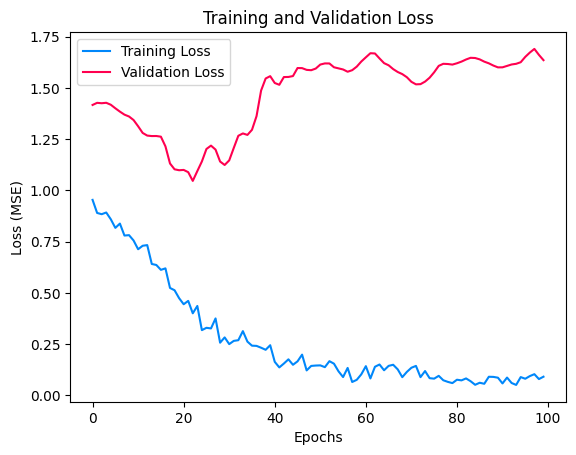

In [49]:
import matplotlib.pyplot as plt



# RGB values for light blue and light pink
light_blue = (0/255, 135/255, 250/255)  # Light blue: RGB(0, 135, 250)
light_pink = (255/255, 0/255, 79/255)  # Light pink: RGB(255, 0, 79)

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss', color=light_blue)
plt.plot(history.history['val_loss'], label='Validation Loss',  color=light_pink)
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


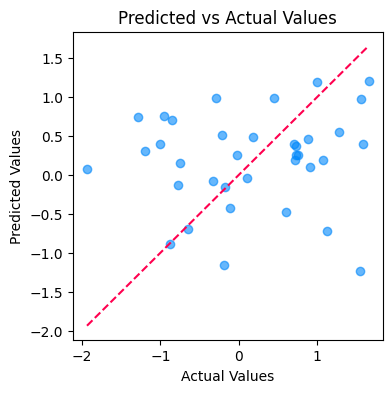

In [50]:
import numpy as np
import matplotlib.pyplot as plt

# RGB values for light blue and light pink
light_blue = (0/255, 135/255, 250/255)  # Light blue: RGB(0, 135, 250)
light_pink = (255/255, 0/255, 79/255)  # Light pink: RGB(255, 0, 79)

# Predicted vs Actual values
plt.figure(figsize=(4, 4))
plt.scatter(y_test, y_pred, alpha=0.6, color=light_blue)  # Scatter plot with blue dots
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color=light_pink)  # Line of perfect prediction in pink
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values')
plt.show()


112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  11%|█         | 4/36 [00:00<?, ?it/s]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  17%|█▋        | 6/36 [00:13<00:27,  1.08it/s]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  19%|█▉        | 7/36 [00:14<00:35,  1.23s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  22%|██▏       | 8/36 [00:16<00:34,  1.22s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  25%|██▌       | 9/36 [00:17<00:36,  1.33s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  28%|██▊       | 10/36 [00:18<00:33,  1.28s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  31%|███       | 11/36 [00:20<00:34,  1.37s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  33%|███▎      | 12/36 [00:21<00:34,  1.43s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  36%|███▌      | 13/36 [00:23<00:34,  1.50s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  39%|███▉      | 14/36 [00:25<00:37,  1.68s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  42%|████▏     | 15/36 [00:27<00:34,  1.63s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  44%|████▍     | 16/36 [00:28<00:30,  1.54s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  47%|████▋     | 17/36 [00:30<00:29,  1.55s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  50%|█████     | 18/36 [00:31<00:26,  1.50s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  53%|█████▎    | 19/36 [00:32<00:25,  1.48s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  56%|█████▌    | 20/36 [00:34<00:23,  1.49s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  58%|█████▊    | 21/36 [00:36<00:23,  1.57s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  61%|██████    | 22/36 [00:38<00:23,  1.68s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  64%|██████▍   | 23/36 [00:40<00:22,  1.74s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  67%|██████▋   | 24/36 [00:41<00:19,  1.66s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  69%|██████▉   | 25/36 [00:42<00:17,  1.59s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  72%|███████▏  | 26/36 [00:44<00:15,  1.59s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  75%|███████▌  | 27/36 [00:46<00:14,  1.59s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  78%|███████▊  | 28/36 [00:47<00:12,  1.52s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  81%|████████  | 29/36 [00:49<00:10,  1.53s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  83%|████████▎ | 30/36 [00:51<00:10,  1.68s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  86%|████████▌ | 31/36 [00:52<00:08,  1.70s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  89%|████████▉ | 32/36 [00:54<00:06,  1.62s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  92%|█████████▏| 33/36 [00:55<00:04,  1.55s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  94%|█████████▍| 34/36 [00:56<00:02,  1.49s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  97%|█████████▋| 35/36 [00:58<00:01,  1.49s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer: 100%|██████████| 36/36 [00:59<00:00,  1.45s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer: 37it [01:01,  1.86s/it]


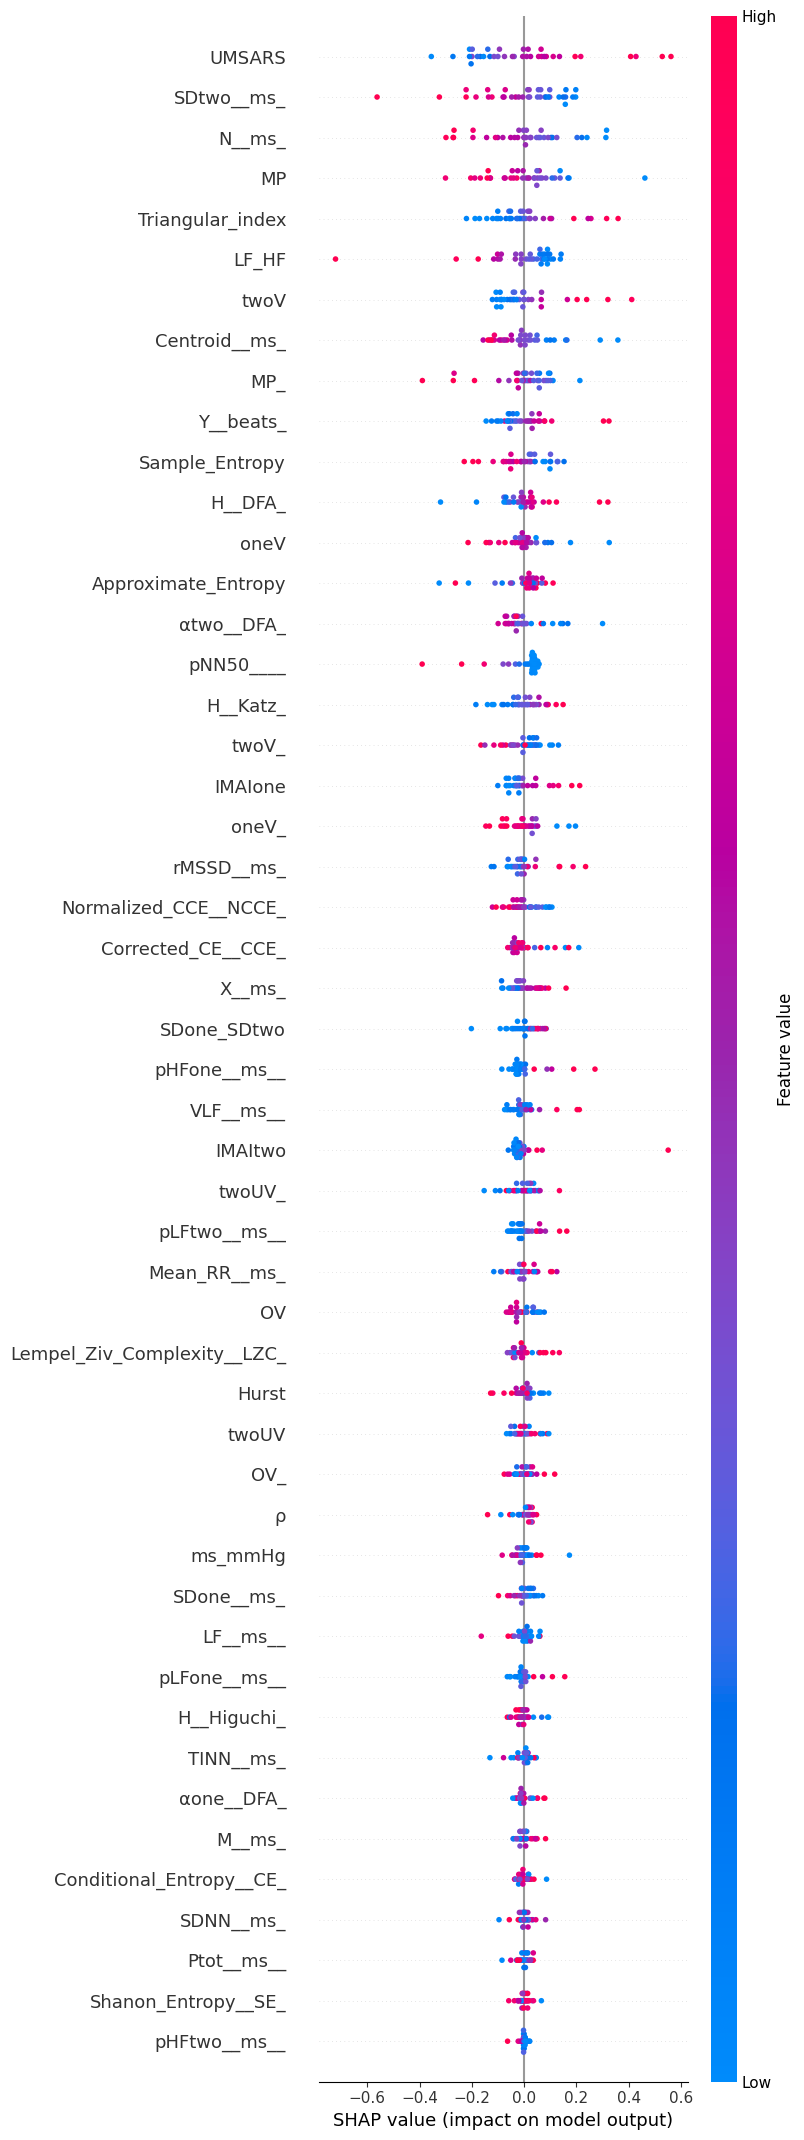

In [51]:
import shap
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Initialize SHAP explainer
explainer = shap.Explainer(best_model.predict, X_test)
shap_values = explainer(X_test)

# Define the custom color palette from midnight blue to dark red
colors = ["midnightblue", "darkred"]
cmap = mcolors.LinearSegmentedColormap.from_list("blue_to_red", colors)


# Summary plot

shap.summary_plot(shap_values, X_test, max_display=50, color=plt.get_cmap("RdBu"))


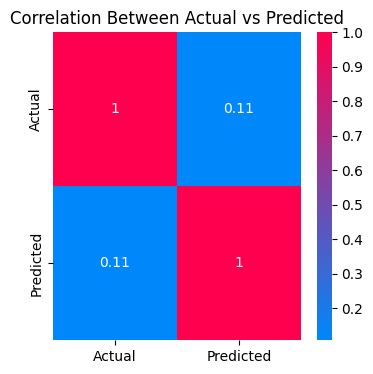

In [52]:
from matplotlib.colors import LinearSegmentedColormap

import seaborn as sns

# Create a DataFrame with actual and predicted values
results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# Define the custom RGB colors for light blue and pink
light_blue = (0/255, 135/255, 250/255)  # RGB (0, 135, 250)
pink = (255/255, 0/255, 79/255)        # RGB (255, 0, 79)

# Create the colormap using the specified colors
cmap = LinearSegmentedColormap.from_list('lightblue_to_pink', [light_blue, pink])


# Correlation heatmap
plt.figure(figsize=(4, 4))

sns.heatmap(results.corr(), annot=True, cmap=cmap)
plt.title('Correlation Between Actual vs Predicted')
plt.show()


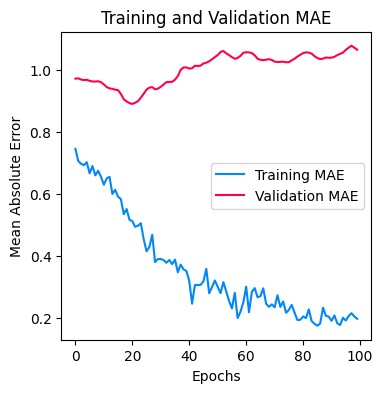

In [53]:
import matplotlib.pyplot as plt

# RGB values for light blue and light pink
light_blue = (0/255, 135/255, 250/255)  # Light blue: RGB(0, 135, 250)
light_pink = (255/255, 0/255, 79/255)  # Light pink: RGB(255, 0, 79)

plt.figure(figsize=(4, 4))
plt.plot(history.history['mae'], label='Training MAE', color=light_blue)
plt.plot(history.history['val_mae'], label='Validation MAE', color=light_pink)
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.title('Training and Validation MAE')
plt.legend()
plt.show()


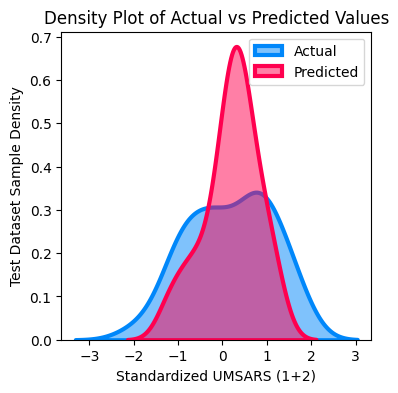

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define the custom RGB colors for light blue and pink
light_blue = (0/255, 135/255, 250/255)  # RGB (0, 135, 250)
pink = (255/255, 0/255, 79/255)        # RGB (255, 0, 79)

# Density plot for actual and predicted values
plt.figure(figsize=(4, 4))
sns.kdeplot(y_test, label='Actual', color=light_blue, linewidth=3,fill=True, alpha=0.5)
sns.kdeplot(y_pred, label='Predicted', color=pink, linewidth=3,fill=True, alpha=0.5)
plt.legend()
plt.title('Density Plot of Actual vs Predicted Values')
plt.xlabel('Standardized UMSARS (1+2)')
plt.ylabel('Test Dataset Sample Density')
plt.show()


In [55]:
best_model.save("best_model.h5")

In [58]:
model_json = best_model.to_json()
with open("model_architecture.json", "w") as json_file:
    json_file.write(model_json)

# Save the model weights
best_model.save_weights("model_v2.weights.h5")

In [59]:
X_test.shape

(36, 51)

In [60]:
X_train.shape

(81, 51)